In [10]:
import os
import os.path as osp
import sys
import pickle


dataset = 'COCO' # {'COCO', 'HF'}

if dataset == 'COCO':
    prFile = '/home/chnxi/Detectron/backfill/COCO_Mask_Detector/coco_2014_minival/classwise_pr_curves.pkl'
    saveClsThrshFile = '/home/chnxi/Detectron/backfill/COCO_Mask_Detector/coco_2014_minival/class_thresholds_at_pr.pkl'
elif dataset == 'HF':
    prFile = '/home/chnxi/Detectron/backfill/HF_Detector/furniture_val/test/furniture_val/retinanet/classwise_pr_curves.pkl'
    saveClsThrshFile = '/home/chnxi/Detectron/backfill/HF_Detector/furniture_val/class_thresholds_at_pr.pkl'
    #labelFile = '/media/data/chnxi/HomeFurniture/taxonomy/furniture_58_labels.txt'
    #classes = [l.rstrip() for l in open(labelFile,'r').readlines()]

    
    
d = pickle.load(open(prFile,'rb'))

recallThrs = d['recallThrs']

all_precs = d['clsPrecisions']

all_scores = d['clsScores']

cls_aps = d['clsAPs']

classes = d['classes'][1:] # remove background
print (classes)
print ("recallThrs.shape = {}, all_precs.shape = {}, all_scores.shape = {}".format(recallThrs.shape, all_precs.shape, all_scores.shape))

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
recallThrs.shape = (101,), all_precs.shape = (80, 101), all_scores.shape = (80, 101)


In [11]:
showCateg = 'wardrobe'
catid = classes.index(showCateg)
print (recallThrs)
print (all_precs[catid])
print (all_scores[catid])
print (d['clsAPs'][catid])
print ("len(scores) = {}".format(len(set(all_precs[catid]))))

ValueError: 'wardrobe' is not in list

Target saving PR thresholds to /home/chnxi/Detectron/backfill/COCO_Mask_Detector/coco_2014_minival/class_thresholds_at_pr.pkl
axarr.size = (5, 2)
<class 'numpy.ndarray'>


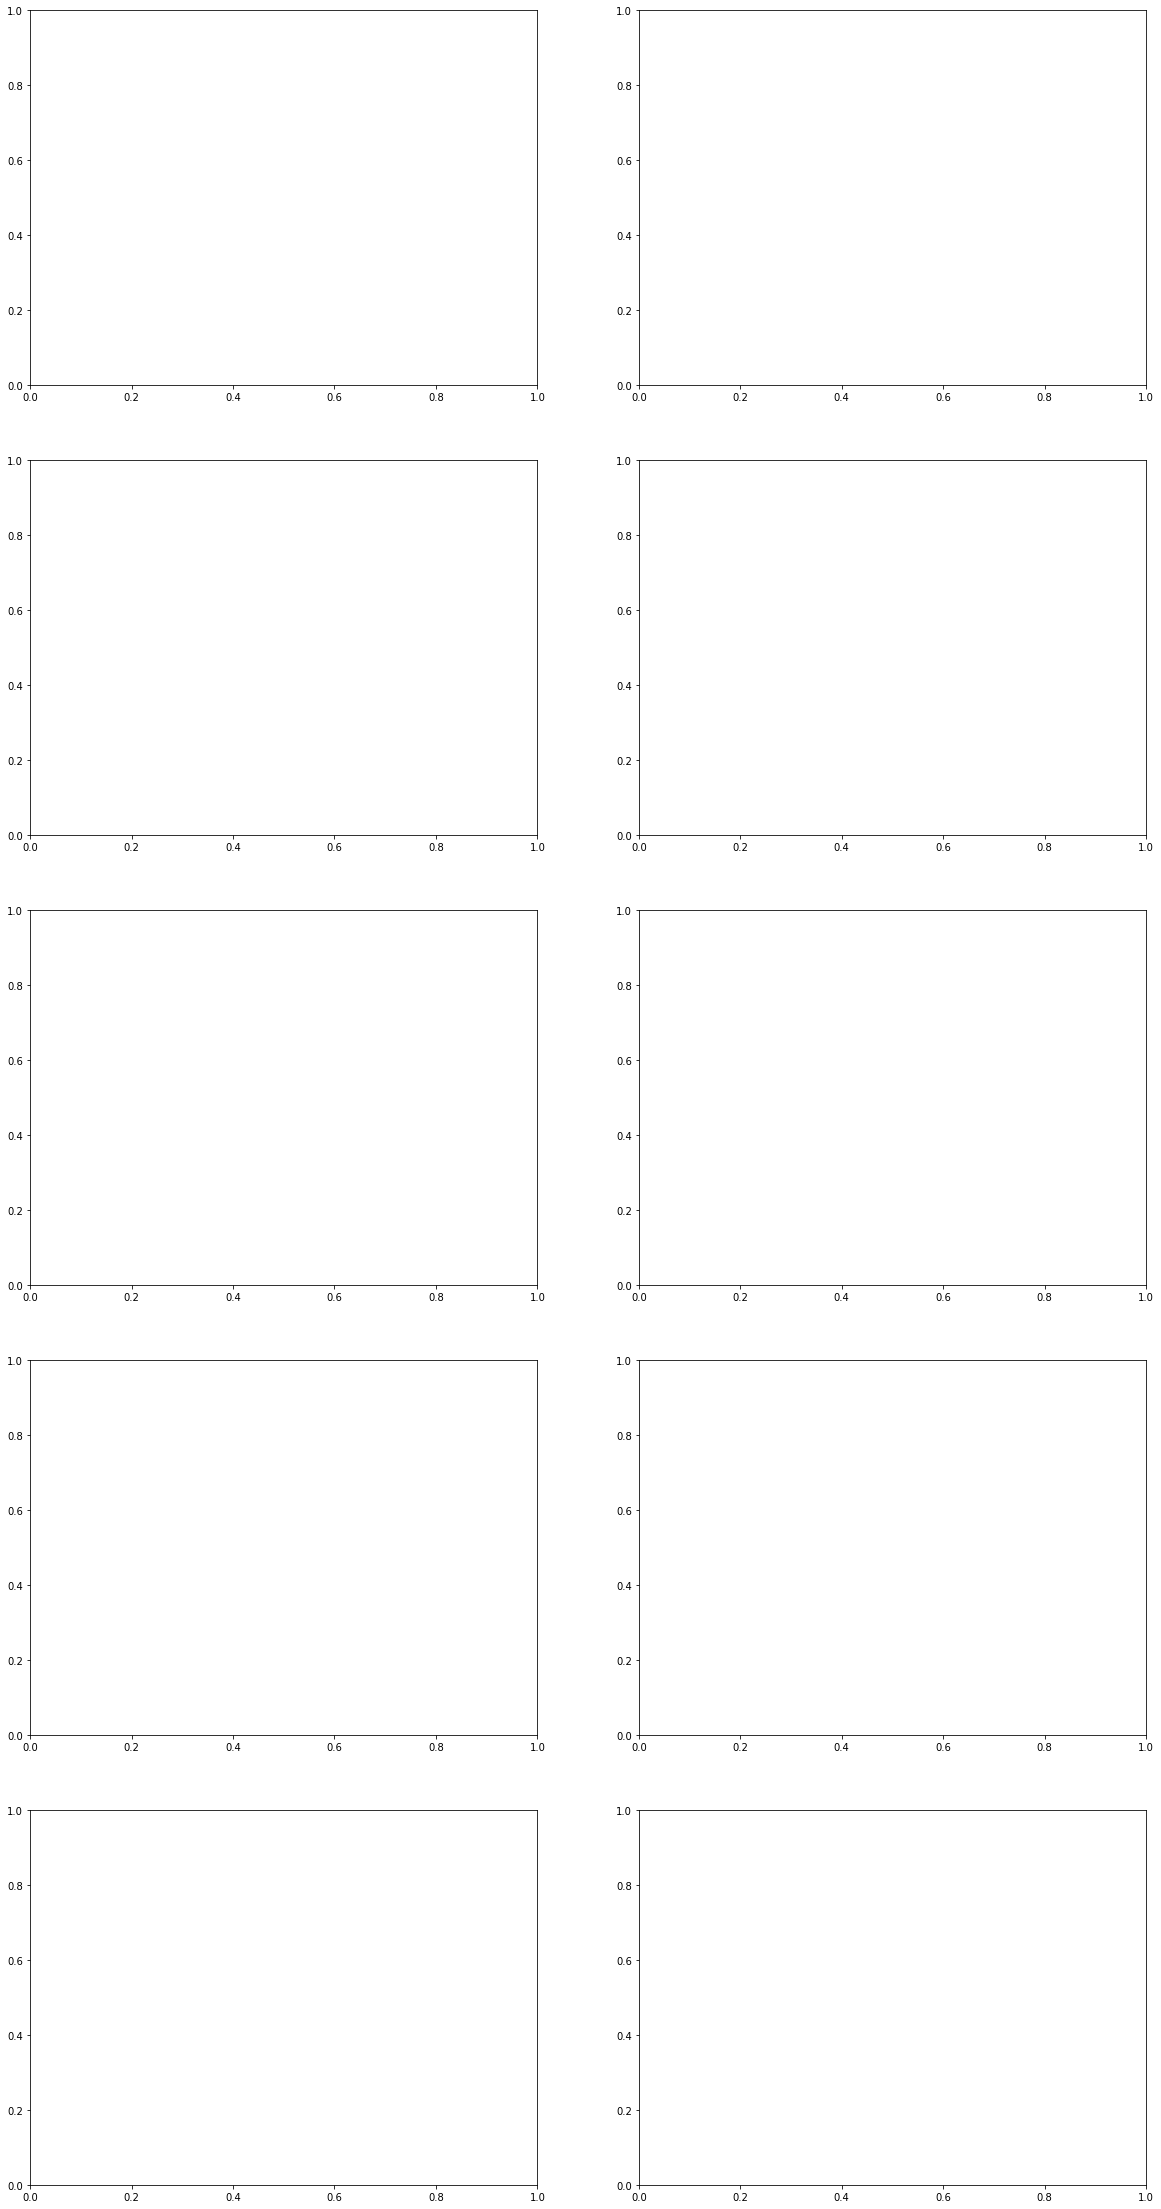

In [16]:
import matplotlib.pyplot as plt
import numpy as np

print ("Target saving PR thresholds to {}".format(saveClsThrshFile))

vis = True
saveThrshFile = False
clsNum = all_precs.shape[0]

classIds = range(clsNum) #[78]
visClsNum = 10

#clsNum = 10

precList = [0.9, 0.8]
recList = [0.7, 0.5]

clsThrshAtPrec = {}
for p in precList:
    clsThrshAtPrec[p] = np.zeros(clsNum)
    
clsThrshAtRec = {}
for r in recList:
    clsThrshAtRec[r] = np.zeros(clsNum)

def findPrecScoreThrsh(prec, pthrsh, scores):
    if len(np.where(prec >= pthrsh)[0]) > 0:
        (p,i) = min((p,i) for (i,p) in enumerate(prec) if p >= pthrsh)
        return scores[i], p, i
    else: # highest precision didin't reach threshold, take the precision/score at the max precision
        max_prec = max(prec)
        max_prec_idx = np.where(prec==max_prec)[0][0]
        return scores[max_prec_idx], max_prec, max_prec_idx

def findRecScoreThrsh(rec, rthrsh, scores):
    idx = int(rthrsh*100)
    return scores[idx], idx

if vis:
    f, axarr = plt.subplots(int(np.ceil(visClsNum/2)), 2, figsize=(20, 4 * visClsNum))
    print ("axarr.size = {}".format(axarr.shape))
    print (type(axarr))
    plt.axis('on')
    major_ticks = np.arange(0., 1, 0.1) 


In [ ]:
for plotid, cid in enumerate(classIds): #range(clsNum-10, clsNum): 
    cls_prec = all_precs[cid,:]
    cls_scores = all_scores[cid,:]
    
    (min_prec,min_prec_idx) = min((p,i) for (i,p) in enumerate(cls_prec) if p > 0)
    maxClsRecall = recallThrs[min_prec_idx]
    score_at_max_cls_recall = cls_scores[min_prec_idx]
    
    #print ("cid={}, min_prec_idx = {}, min_prec = {}, max_recall = {}, score_at_max_cls_recall = {}".format(cid, min_prec_idx, min_prec, maxClsRecall, score_at_max_cls_recall))
    
    for p in precList:
        score_at_p_thrsh, p_at_thrsh, pidx = findPrecScoreThrsh(cls_prec, p, cls_scores)
        clsThrshAtPrec[p][cid] = score_at_p_thrsh
        
    for r in recList:
        score_at_r_thrsh, ridx = findRecScoreThrsh(recallThrs, r, cls_scores)
        clsThrshAtRec[r][cid] = max(score_at_r_thrsh, score_at_max_cls_recall)
        
    #print ("P@{} Score = {}, real precision = {}".format(0.9, score_p_at_thrsh, p_at_thrsh))
    if vis and plotid < visClsNum:
        ax = axarr[plotid]
        ax.set_xticks(major_ticks)                                                       
        ax.set_yticks(major_ticks)                                                       
        ax.plot(recallThrs, cls_prec, 'b-')
        ax.annotate('PR=({:.3f}, {:.3f}):{:.3f}'.format(cls_prec[pidx], recallThrs[pidx], cls_scores[pidx]), xy=(recallThrs[pidx], cls_prec[pidx]))
        ax.annotate('PR=({:.3f}, {:.3f}):{:.3f}'.format(cls_prec[ridx], recallThrs[ridx], cls_scores[ridx]), xy=(recallThrs[ridx], cls_prec[ridx]))  
        ax.set_title('class {}: AP={:.1f}'.format(classes[cid], cls_aps[cid]*100))
        ax.grid()

plt.show()

print ("clsThrshAtPrec = {}".format(clsThrshAtPrec))
print ("clsThrshAtRec = {}".format(clsThrshAtRec))

class_thresholds = {'prec_at':clsThrshAtPrec, 
                    'rec_at':clsThrshAtRec, 
                    'classes': classes,
                     'cls_aps': cls_aps}

if saveThrshFile:
    with open(saveClsThrshFile, 'wb') as f:
        pickle.dump(class_thresholds, f)    
    print ("Saved to {}".format(saveClsThrshFile))


In [ ]:
plt.show()